In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from scipy import stats
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
df1 = pd.read_csv('../csv/keisuke1.csv',header=0)
df2 = pd.read_csv('../csv/keisuke2.csv',header=0)
df3 = pd.read_csv('../csv/keisuke3.csv',header=0)
df4 = pd.read_csv('../csv/keisuke4.csv',header=0)

In [3]:
df1 = df1.drop(df1[df1.STATE==1].index)
df2 = df2.drop(df2[df2.STATE==1].index)
df3 = df3.drop(df3[df3.STATE==1].index)
df4 = df4.drop(df4[df4.STATE==1].index)

In [4]:
df1.head()

,SEC,GSR,STATE
60,60,384,2
61,61,389,2
62,62,395,2
63,63,384,2
64,64,366,2


In [25]:
def create_data(X,Y):
    time_step=32;
    Xs = []
    Ys = []
#     Ys = np.zeros((X.size-time_step,2))
    for i in range(0,X.size-time_step,1):
        
        tmp = X.iloc[i:(i+time_step)]
        
        labels = Y.iloc[i:(i+time_step)]
        Xs.append(tmp)
        
        
        if stats.mode(labels)[0][0] == 2:
            Ys.append((stats.mode(labels)[0][0])-1)
        else:
            Ys.append((stats.mode(labels)[0][0])-3)
        
    return np.array(Xs),np.array(Ys).reshape(-1,1)

In [26]:
#TRAIN
X_train,Y_train= create_data(df2['GSR'],df2['STATE'])

tmp1, tmp2 = create_data(df4['GSR'],df4['STATE'])
X_train = np.concatenate((X_train,tmp1),axis=0)
print(X_train.shape)
Y_train = np.concatenate((Y_train,tmp2),axis=0)

X_train = X_train.astype('float32')
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std

X_train = np.reshape(X_train,[X_train.shape[0],X_train.shape[1],1])
#Y_train = np.reshape(Y_train,[1,Y_train.shape[0],Y_train.shape[1]])

(656, 32)


In [7]:
#VAL
X_val, Y_val = create_data(df3['GSR'],df3['STATE'])

X_val = X_val.astype('float32')
X_val -= mean
X_val /= std

X_val = np.reshape(X_val,[X_val.shape[0],X_val.shape[1],1])

In [8]:
#TEST
X_test, Y_test = create_data(df1['GSR'],df1['STATE'])

X_test = X_test.astype('float32')
X_test -= mean
X_test /= std

X_test = np.reshape(X_test,[X_test.shape[0],X_test.shape[1],1])
#Y_test = np.reshape(Y_test,[1,Y_test.shape[0],Y_test.shape[1]])

In [9]:
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape,X_test.shape,Y_test.shape)

(656, 32, 1) (656, 1) (328, 32, 1) (328, 1) (328, 32, 1) (328, 1)


In [12]:
model = keras.Sequential()

In [13]:
model.add(keras.layers.LSTM(8, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=['acc'])

In [14]:
history = model.fit(X_train,
                   Y_train,
                   epochs=4,
                    batch_size=64,
                    validation_data=(X_val,Y_val),
                   shuffle=False)

Epoch 1/4
11/11 [==============================] - 3s 42ms/step - loss: 0.6841 - acc: 0.5671 - val_loss: 0.6822 - val_acc: 0.4965
Epoch 2/4
11/11 [==============================] - 0s 5ms/step - loss: 0.6774 - acc: 0.5809 - val_loss: 0.6835 - val_acc: 0.4964
Epoch 3/4
11/11 [==============================] - 0s 5ms/step - loss: 0.6782 - acc: 0.5814 - val_loss: 0.6847 - val_acc: 0.4966
Epoch 4/4
11/11 [==============================] - 0s 5ms/step - loss: 0.6789 - acc: 0.5780 - val_loss: 0.6860 - val_acc: 0.4968


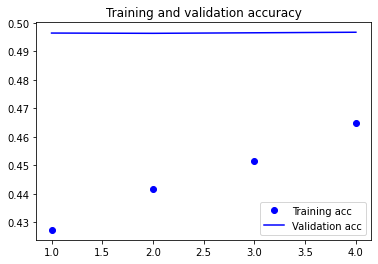

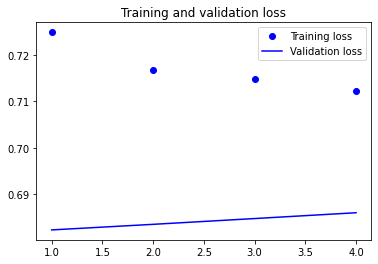

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.evaluate(X_test,Y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.6754 - acc: 0.6303


[0.6754345893859863, 0.6303353905677795]